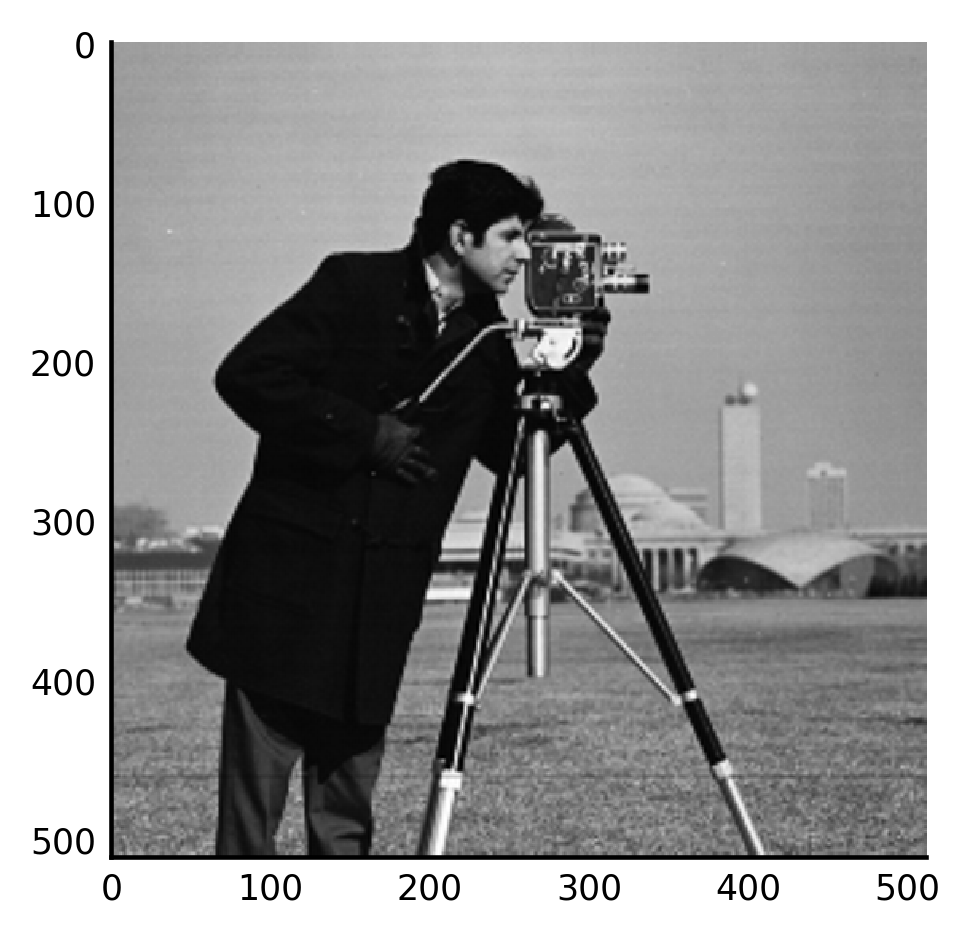

In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

from skimage import data
image = data.camera()
plt.imshow(image);

In [3]:
import numpy as np
from scipy import sparse
from itertools import product

def homography(tf, image_shape):
    """Represent homographic transformation & interpolation as linear operator.

    Parameters
    ----------
    tf : (3, 3) ndarray
        Transformation matrix.
    image_shape : (M, N)
        Shape of input gray image.

    Returns
    -------
    A : (M * N, M * N) sparse matrix
        Linear-operator representing transformation + bilinear interpolation.

    """
    # Invert matrix.  This tells us, for each output pixel, where to
    # find its corresponding input pixel.
    H = np.linalg.inv(tf)

    m, n = image_shape

    # We are going to construct a COO matrix, often called IJK matrix,
    # for which we'll need row coordinates (I), column coordinates (J),
    # and values (K).
    row, col, values = [], [], []

    # For each pixel in the output image...
    for sparse_op_row, (out_row, out_col) in \
            enumerate(product(range(m), range(n))):

        # Compute where it came from in the input image
        in_row, in_col, in_abs = H @ [out_row, out_col, 1]
        in_row /= in_abs
        in_col /= in_abs

        # if the coordinates are outside of the original image, ignore this
        # coordinate; we will have 0 at this position
        if (not 0 <= in_row < m - 1 or
                not 0 <= in_col < n - 1):
            continue

        # We want to find the four surrounding pixels, so that we
        # can interpolate their values to find an accurate
        # estimation of the output pixel value.
        # We start with the top, left corner, noting that the remaining
        # points are 1 away in each direction.
        top = int(np.floor(in_row))
        left = int(np.floor(in_col))

        # Calculate the position of the output pixel, mapped into
        # the input image, within the four selected pixels.
        # https://commons.wikimedia.org/wiki/File:BilinearInterpolation.svg
        t = in_row - top
        u = in_col - left

        # The current row of the sparse operator matrix is given by the
        # raveled output pixel coordinates, contained in sparse_op_row.
        # We will take the weighted average of the four surrounding input
        # pixels, corresponding to four columns. So we need to repeat the row
        # index four times.
        row.extend([sparse_op_row] * 4)

        # The actual weights are calculated according to the bilinear
        # interpolation algorithm, as shown at
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        sparse_op_col = np.ravel_multi_index(
                ([top,  top,      top + 1, top + 1 ],
                 [left, left + 1, left,    left + 1]), dims=(m, n))
        col.extend(sparse_op_col)
        values.extend([(1-t) * (1-u), (1-t) * u, t * (1-u), t * u])

    operator = sparse.coo_matrix((values, (row, col)),
                                 shape=(m*n, m*n)).tocsr()
    return operator

In [4]:
angle = 30
c = np.cos(np.deg2rad(angle))
s = np.sin(np.deg2rad(angle))

H = np.array([[c, -s,  0],
              [s,  c,  0],
              [0,  0,  1]])

In [5]:
def apply_transform(image, tf):
    return (tf @ image.flat).reshape(image.shape)

In [6]:
def transform_rotate_about_center(shape, degrees):
    """Return the homography matrix for a rotation about an image center."""
    c = np.cos(np.deg2rad(angle))
    s = np.sin(np.deg2rad(angle))

    H_rot = np.array([[c, -s,  0],
                      [s,  c,  0],
                      [0,  0,  1]])
    # compute image center coordinates
    center = np.array(image.shape) / 2
    # matrix to center image on origin
    H_tr0 = np.array([[1, 0, -center[0]],
                      [0, 1, -center[1]],
                      [0, 0,          1]])
    # matrix to move center back
    H_tr1 = np.array([[1, 0, center[0]],
                      [0, 1, center[1]],
                      [0, 0,         1]])
    # complete transformation matrix
    H_rot_cent = H_tr1 @ H_rot @ H_tr0

    sparse_op = homography(H_rot_cent, image.shape)

    return sparse_op

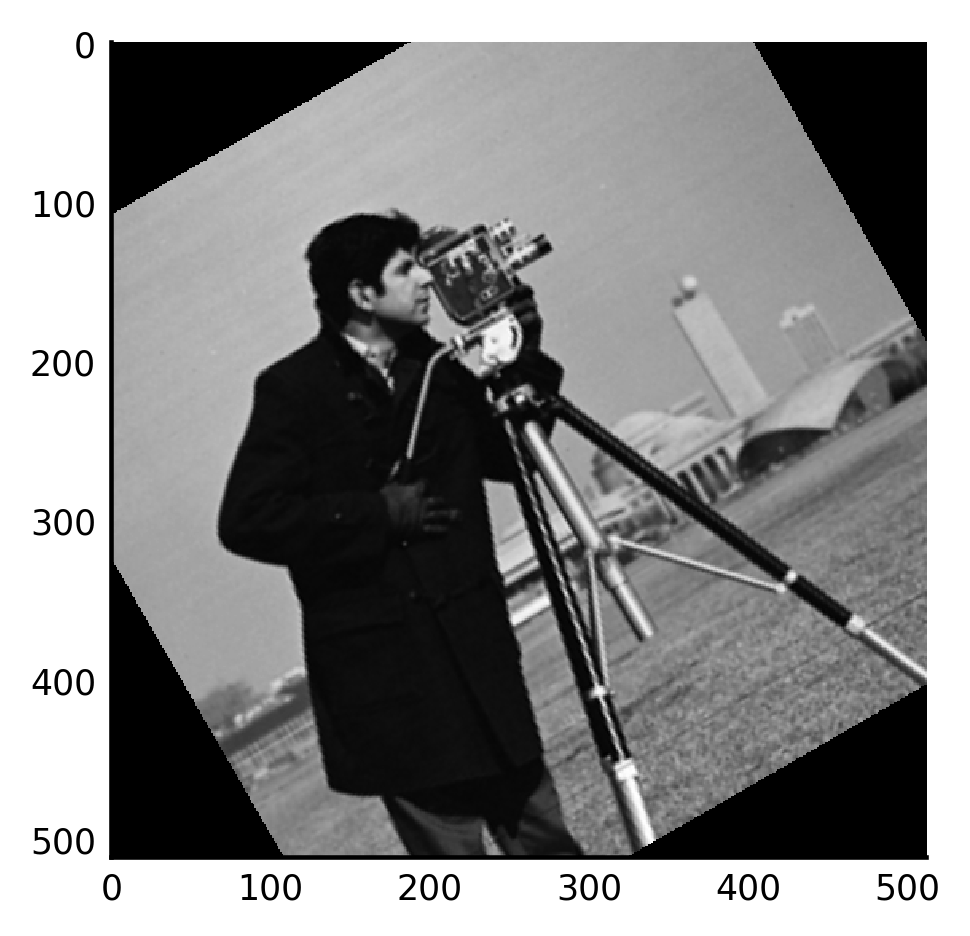

In [7]:
tf = transform_rotate_about_center(image.shape, 30)
plt.imshow(apply_transform(image, tf));